In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Direction reconstruction (TRAINING)

**Recommended datasample(s):** ``gamma1`` (dataset used to build the energy model)

**Data level(s):** DL1b (telescope-wise image parameters) + DL2 (only shower geometry)

**Description:**

This notebook contains plots and benchmarks proposals from the _protopipe_ pipeline related to shower geometry reconstruction.

**Requirements and steps to reproduce:**

- get a TRAINING file generated using ``protopipe-TRAINING`` or the equivalent command from the DIRAC Grid interface
- execute the notebook with ``protopipe-BENCHMARK``,

``protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n TRAINING/benchmarks_DL2_direction-reconstruction``

To obtain the list of all available parameters add ``--help-notebook``.

**Comparison against CTAMARS:**

- the input file needs to be a merged TRAINING file from the gamma1 sample
- LST stereo condition needs to have been activated when launching ``protopipe-TRAINING`` for the 4 LSTs + 15 MSTs North baseline
- reference simtel-files, plots, values and settings can be found [here (please, always refer to the latest version)](https://forge.in2p3.fr/projects/benchmarks-reference-analysis/wiki/Comparisons_between_pipelines).

**Development and testing:**  

As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.   
The execution of this notebook is not currently automatic, it must be done locally by the user _before_ pushing a pull-request.  
Please, strip the output before pushing.

## Table of contents
- [Angular resolution vs true energy](#Angular-resolution-vs-true-energy)
- [Reconstruction efficiency relative to the number of stereoscopic triggers](#Reconstruction-efficiency-relative-to-the-number-of-stereoscopic-triggers)
- [Distribution of true core positions for reconstructed events](#Distribution-of-true-core-positions-for-reconstructed-events)
- [Shower core reconstruction](#Shower-core-reconstruction)
- [Correlation between H_max and atmospheric depth](#Correlation-between-H_max-and-atmospheric-depth)
- [Impact distances](#Impact-distances)

## Imports

In [2]:
import os
from pathlib import Path
import warnings

def fxn():
    warnings.warn("runtime", RuntimeWarning)

from astropy.coordinates.angle_utilities import angular_separation
import tables
import pandas
import seaborn as sns
import numpy as np
import uproot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.pyplot import rc
import matplotlib.style as style
from cycler import cycler

from protopipe.pipeline.io import get_camera_names, read_protopipe_TRAINING_per_tel_type

## Functions

In [3]:
# TODO: move to protopipe.benchmarks.utils
def raise_(ex):
    """Raise an exception as a statement.
    
    This is a general purpose raiser for cases such as a lambda function.
    
    Parameters
    ----------
    ex: exception
        Python built-in exception to raise.
    """
    raise ex

# TODO: move to protopipe.benchmarks.utils
def string_to_boolean(variables):
    """Convert True/False strings to booleans.
    
    Useful in case a specific use of the CLI doesn't allow to read booleans as booleans.
    
    Parameters
    ----------
    variables: list of str
        Variables to check.
    """
    
    def check_str(x): return x if type(x) == bool \
        else True if x == "True" \
        else False if x == "False" \
        else raise_(ValueError(f"{x} is not a valid boolean."))
    
    return list(map(check_str, variables))

## Input data
[back to top](#Table-of-contents)

### Protopipe
[back to top](#Table-of-contents)

In [4]:
# Parametrized cell
load_CTAMARS = True # Enable to compare the CTAN analysis done with CTAMARS (Release 2019)
analyses_directory = None
output_directory = Path.cwd() # default output directory for plots
analysis_name = None
input_filename = None # Name of the file produced with protopipe
indir_CTAMARS = None  # Path to CTAMARS data (if load_CTAMARS is True)
input_file_name_CTAMARS = "CTA_check_dl2_4L15M.root" # Name of the CTAMARS reference file to use (if load_CTAMARS is True)
input_simtel_filepath = None # simtel file used to plot telescope positions
allowed_tels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 19, 35] # array to use (TODO: read from analysis.yaml)
use_seaborn = False # If True import seaborn and apply global settings from config file
export_data = True # If True export data in CSV format
superimpose_analysis_2 = False # If True superimpose results from 'analysis_name_2' data files (requires that 'export_data' was True)
analysis_name_2 = None

In [5]:
# Parameters
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses"
analysis_name = "v0.5.0a1"
load_protopipe_previous = False
analysis_name_2 = "v0.4.0_dev1"
use_seaborn = True
matplotlib_settings = {
    "cmap": "cividis",
    "style": "seaborn-colorblind",
    "rc": {"font_size": 8, "font_family": "Fira Sans"},
    "scale": 1.5,
}
seaborn_settings = {
    "theme": {"style": "whitegrid", "context": "talk"},
    "rc_context": {},
    "rc_style": {"xtick.bottom": True, "ytick.left": True},
}
load_requirements = True
requirements_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/requirements/"
load_CTAMARS = True
input_data_CTAMARS = {
    "parent_directory": "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data",
    "TRAINING/DL1": "TRAINING/DL1",
    "TRAINING/DL2": "TRAINING/DL2",
    "DL2": "",
    "DL3": {
        "input_directory": "DL3",
        "input_file": "SubarrayLaPalma_4L15M_south_IFAE_50hours_20190630.root",
    },
    "label": "CTAMARS (2019)",
}
load_EventDisplay = True
input_data_EventDisplay = {
    "input_directory": "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203",
    "input_file": "CTA-Performance-North-20deg-S-50h_20181203.root",
    "label": "EventDisplay (2018)",
}
input_filenames = {
    "simtel": "/Users/michele/Applications/ctasoft/tests/data/simtel/gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz",
    "TRAINING_energy_gamma": "TRAINING_energy_tail_gamma_merged.h5",
    "TRAINING_classification_gamma": "TRAINING_classification_tail_gamma_merged.h5",
    "DL2_gamma": "DL2_tail_gamma_merged.h5",
    "DL2_proton": "DL2_energy_tail_gamma_merged.h5",
    "DL2_electron": "DL2_energy_tail_gamma_merged.h5",
    "DL3": "performance_protopipe_Prod3b_CTANorth_baseline_full_array_Zd20deg_180deg_Time50.00h.fits.gz",
}
model_configuration_filenames = {
    "energy": "RandomForestRegressor.yaml",
    "classification": "RandomForestClassifier.yaml",
}
input_filenames_ctapipe = {
    "DL1a_gamma": "events_protopipe_CTAMARS_calibration_1stPass.dl1.h5",
    "DL1a_gamma_2ndPass": "events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5",
}
output_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/v0.5.0a1/benchmarks_results/TRAINING"


In [6]:
# Handle boolean variables (papermill reads them as strings)
[load_CTAMARS,
 load_EventDisplay,
 use_seaborn,
 export_data,
 superimpose_analysis_2] = string_to_boolean([load_CTAMARS,
                                              load_EventDisplay,
                                              use_seaborn,
                                              export_data,
                                              superimpose_analysis_2])

In [7]:
if input_filename is None:
    try:
        input_filename = input_filenames["TRAINING_energy_gamma"]
    except (NameError, KeyError):
        raise ValueError("The name of the input file is undefined: please use benchmarks.yaml or define it using the CLI.")

if input_simtel_filepath is None:
    try:
        input_simtel_filepath = Path(input_filenames["simtel"])
    except (NameError, KeyError, TypeError):
        input_simtel_filepath = None # a warning is print later
    finally:
        if (input_filenames["simtel"]==""):
            input_simtel_filepath = None
else:
    input_simtel_filepath = Path(input_simtel_filepath)
    
input_directory = Path(analyses_directory) / analysis_name / Path("data/TRAINING/for_energy_estimation/gamma")
cameras = get_camera_names(input_directory, input_filename)
data = read_protopipe_TRAINING_per_tel_type(input_directory, input_filename, cameras)

### CTA-MARS

In [8]:
if load_CTAMARS:
    
    if not indir_CTAMARS:
        try:
            indir_CTAMARS = Path(input_data_CTAMARS["parent_directory"]) / Path(input_data_CTAMARS["TRAINING/DL2"])
        except (NameError, KeyError):
            print("WARNING: CTAMARS data undefined! Please, check the documentation of protopipe-BENCHMARKS.")

    path_mars_dl2a = indir_CTAMARS / input_file_name_CTAMARS

    CTAMARS_data = {}
    with uproot.open(path_mars_dl2a) as CTAMARS:
        for key in CTAMARS.keys():
            CTAMARS_data[key.split(";")[0]] = CTAMARS[key]

## Plots and benchmarks
[back to top](#Table-of-contents)

In [9]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
plots_folder = Path(output_directory) / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)

# Next we check if a _data_ folder exists already.  
# If not, we create it.
data_folder = Path(output_directory) / "data"
data_folder.mkdir(parents=True, exist_ok=True)

input_directory_data_2 = Path(analyses_directory) / analysis_name_2/ "benchmarks_results/TRAINING"

In [10]:
# Plot aesthetics settings

style.use(matplotlib_settings["style"])
cmap = matplotlib_settings["cmap"]

if matplotlib_settings["style"] == "seaborn-colorblind":
    
    colors_order = ['#0072B2', '#D55E00', '#F0E442', '#009E73', '#CC79A7', '#56B4E9']
    rc('axes', prop_cycle=cycler(color=colors_order))

if use_seaborn:
    import seaborn as sns

    sns.set_theme(context=seaborn_settings["theme"]["context"] if "context" in seaborn_settings["theme"] else "talk",
                  style=seaborn_settings["theme"]["style"] if "style" in seaborn_settings["theme"] else "whitegrid",
                  palette=seaborn_settings["theme"]["palette"] if "palette" in seaborn_settings["theme"] else None,
                  font=seaborn_settings["theme"]["font"] if "font" in seaborn_settings["theme"] else "Fira Sans",
                  font_scale=seaborn_settings["theme"]["font_scale"] if "font_scale" in seaborn_settings["theme"] else 1.0,
                  color_codes=seaborn_settings["theme"]["color_codes"] if "color_codes" in seaborn_settings["theme"] else True
                  )
    
    sns.set_style(seaborn_settings["theme"]["style"], rc=seaborn_settings["rc_style"])
    sns.set_context(seaborn_settings["theme"]["context"],
                    font_scale=seaborn_settings["theme"]["font_scale"] if "font_scale" in seaborn_settings["theme"] else 1.0)

In [11]:
if load_CTAMARS:

    true_energy_bin_edges = CTAMARS["reco_fraction"].to_numpy()[1]
    true_energy_bin_centers = CTAMARS["angres"].member("fX")

else:
    
    true_energy_bin_edges = np.arange(-1.9, 2.5, 0.2) # TeV
    true_energy_bin_centers = 0.5 * (true_energy_bin_edges[1:]+true_energy_bin_edges[:-1])

In [12]:
# first merge cameras
for i, camera in enumerate(cameras):
    if i==0:
        all_images = data[camera]
    else:
        all_images = all_images.append(data[camera])

# then drop duplicate rows based on some simulation information
all_unique_triggered_showers = all_images.drop_duplicates(subset=["obs_id",
                                                        "event_id",
                                                        "true_energy"
                                                       ])

# then select only showers with a valid stereoscopic reconstruction (+ LST_stereo condition if any)
valid_reconstruction = "is_valid==True"
all_unique_reconstructed_showers = all_unique_triggered_showers.query(valid_reconstruction)

### Angular resolution vs true energy
[back to top](#Table-of-contents)

**Note**  
This benchmark should use events with >=2 valid images, and if using prod3b requiring LST-subarray stereo trigger, i.e. either 0 or >=2 triggered LSTs - since LST-subarray hardware trigger was not required in that simulation

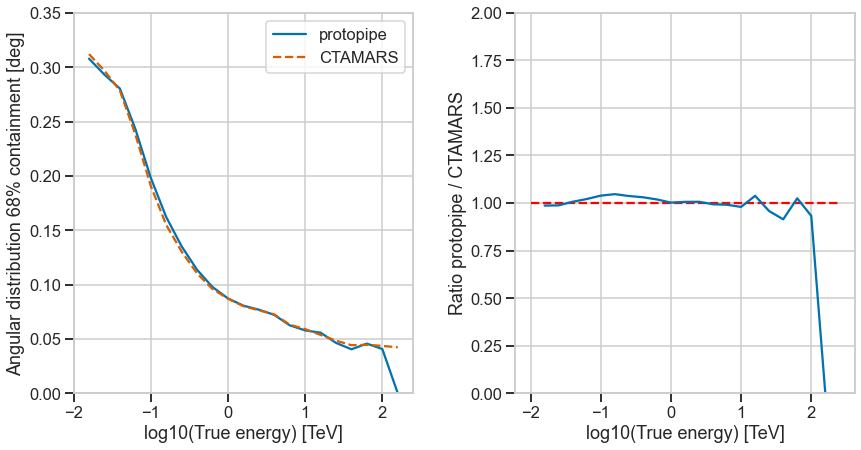

In [13]:
if load_CTAMARS:
    plt.figure(figsize=(14, 7), tight_layout=False)
    plt.subplot(1, 2, 1)
    if use_seaborn:
        plt.subplots_adjust(wspace=0.3)
else:
    plt.figure(figsize=(7, 7))

plt.xlabel("log10(True energy) [TeV]")
plt.ylabel("Angular distribution 68% containment [deg]")

# protopipe

theta = {}
ang_res = np.zeros(len(true_energy_bin_centers))
    
true_energy = np.log10(all_unique_reconstructed_showers["true_energy"])
offset = all_unique_reconstructed_showers["offset"]

for i in range(len(true_energy_bin_centers)-1):

    mask = (true_energy > true_energy_bin_edges[i]) & (true_energy <= true_energy_bin_edges[i + 1])
    selected_offsets = np.sort(offset[mask])
    if len(selected_offsets)==0:
        ang_res[i]=np.nan
    else:
        ang_res[i] = np.percentile(selected_offsets, 68.0)

if export_data:
    data_to_write = np.array([true_energy_bin_centers,ang_res])
    np.savetxt(data_folder / f"training_angular_resolution_protopipe_{analysis_name}.csv",
               data_to_write.T,
               delimiter=',',
               header="True energy bin center [TeV], Angular resolution [deg]")
    
plt.plot(true_energy_bin_centers, ang_res, '-', label = "protopipe")

if superimpose_analysis_2:
    data_2 = np.genfromtxt(input_directory_data_2 / f"data/training_angular_resolution_protopipe_{analysis_name_2}.csv",
                          delimiter=',',
                          filling_values=True).T
    plt.plot(data_2[0], data_2[1], '-.', label = f"protopipe {analysis_name_2}")
    plt.legend()

plt.ylim(0.01,0.35)
plt.grid(which="both", visible=True)

if load_CTAMARS:
    
    # CTAMARS
    plt.plot(true_energy_bin_centers, CTAMARS["angres"].member("fY"), '--', label = "CTAMARS")

    plt.grid(which="both")
    plt.legend()

    plt.ylim(0.,0.35)
    plt.grid(which="both", visible=True)
    
    plt.subplot(1,2,2)

    plt.xlabel("log10(True energy) [TeV]")
    plt.ylabel("Ratio protopipe / CTAMARS")

    plt.plot(true_energy_bin_centers, ang_res/CTAMARS["angres"].member("fY"), '-', label = "CTAMARS")
    plt.hlines(1.0, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], linestyle= '--', color="red")
    plt.ylim(0, 2)
    plt.grid(which="both", visible=True)

plt.savefig(plots_folder / f"training_angular_resolution_protopipe_{analysis_name}.png")
plt.show()

### Reconstruction efficiency relative to the number of stereoscopic triggers
[back to top](#Table-of-contents)

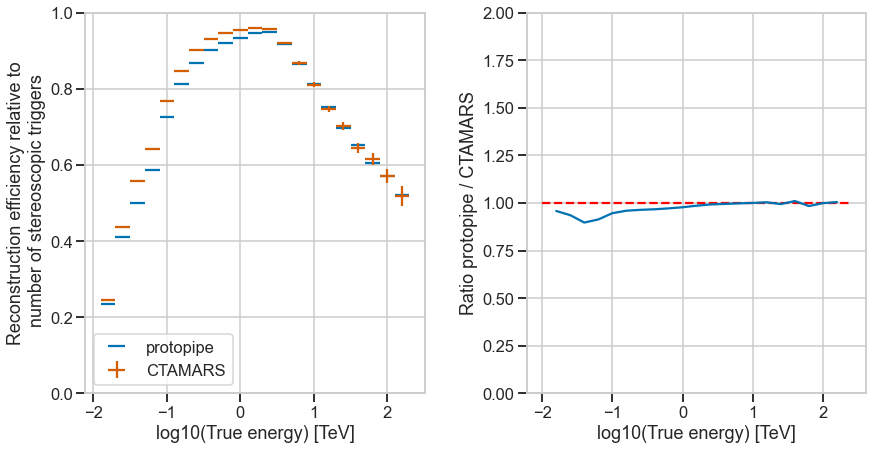

In [14]:
H_all = np.histogram(np.log10(all_unique_triggered_showers["true_energy"]), bins=true_energy_bin_edges)
H_reco = np.histogram(np.log10(all_unique_reconstructed_showers["true_energy"]), bins=true_energy_bin_edges)
reconstruction_efficiency = H_reco[0] / H_all[0]

if load_CTAMARS:
    plt.figure(figsize=(14, 7), tight_layout=False)
    plt.subplot(1, 2, 1)
    if use_seaborn:
        plt.subplots_adjust(wspace=0.3)
else:
    plt.figure(figsize=(7, 7))

plt.xlabel("log10(True energy) [TeV]")
plt.ylabel("Reconstruction efficiency relative to\n number of stereoscopic triggers")

xerr = np.diff(true_energy_bin_edges)/2

if export_data:
    data_to_write = np.array([true_energy_bin_centers,
                              xerr,
                              reconstruction_efficiency])
    np.savetxt(data_folder / f"training_reconstruction_efficiency_protopipe_{analysis_name}.csv",
               data_to_write.T,
               delimiter=',',
               header="True energy bin center [TeV], True enery bin width [TeV], Reconstruction efficiency")

plt.errorbar(true_energy_bin_centers, 
             reconstruction_efficiency, 
             xerr=xerr, 
             yerr = None, 
             ls='none', 
             label = "protopipe")

if superimpose_analysis_2:
    data_2 = np.genfromtxt(input_directory_data_2 / f"data/training_reconstruction_efficiency_protopipe_{analysis_name_2}.csv",
                          delimiter=',',
                          filling_values=True).T
    plt.errorbar(data_2[0], 
                 data_2[2], 
                 xerr=data_2[1], 
                 yerr = None, 
                 ls='none', 
                 label = f"protopipe {analysis_name_2}")
    plt.legend()

if load_CTAMARS:
    plt.errorbar(x = true_energy_bin_centers,
                 y = CTAMARS["reco_fraction"].to_numpy()[0],
                 xerr = np.diff(true_energy_bin_edges)/2,
                 yerr = CTAMARS["reco_fraction"].errors(),
                 ls='none',
                 label = "CTAMARS")

    plt.legend()

plt.ylim(0,1)
plt.grid(which="both", visible=True)

if load_CTAMARS:
    plt.subplot(1,2,2)

    plt.xlabel("log10(True energy) [TeV]")
    plt.ylabel("Ratio protopipe / CTAMARS")

    plt.plot(true_energy_bin_centers,
             reconstruction_efficiency/CTAMARS["reco_fraction"].to_numpy()[0],
             '-')
    plt.hlines(1.0, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], linestyle= '--', color="red")
    plt.ylim(0, 2)


plt.savefig(plots_folder / f"training_reconstruction_efficiency_protopipe_{analysis_name}.png")
plt.show()

### Distribution of true core positions for reconstructed events
[back to top](#Table-of-contents)

In [15]:
# Not important which simtel you use, just be sure it is from the same simulation
if (input_simtel_filepath is None) or (str(input_simtel_filepath)==""):
    print("WARNING: undefined simtel file; telescope positions not available for plotting.")
else:
    from ctapipe.core.traits import TraitError
    try:
        from ctapipe.io import EventSource
        source = EventSource(input_url=Path(input_simtel_filepath), max_events=1, allowed_tels=set(allowed_tels))
        tel_positions = source.subarray.positions
    except (TraitError, KeyError):
        tel_positions = None

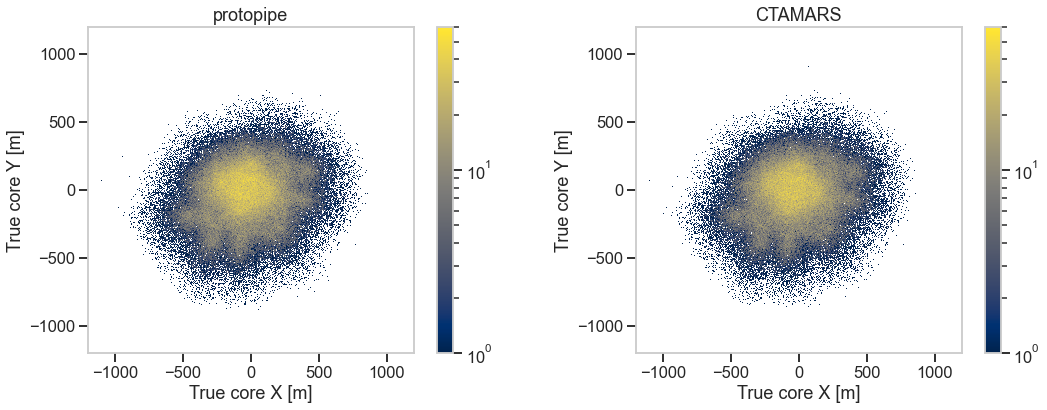

In [16]:
if load_CTAMARS:

    core_distribution_bin_edges_X = CTAMARS["histcore"].axes[0].edges()
    core_distribution_bin_edges_Y = CTAMARS["histcore"].axes[1].edges()

else:
    
    core_distribution_bin_edges_X = np.arange(-1200,1204,4)
    core_distribution_bin_edges_Y = np.arange(-1200,1204,4)

if load_CTAMARS:
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.title("protopipe")
else:
    plt.figure(figsize=(7, 7))

plt.gca().set_aspect('equal')

core_distribution = plt.hist2d(x = -all_unique_reconstructed_showers["mc_core_y"],
                               y = all_unique_reconstructed_showers["mc_core_x"],
                               bins=[core_distribution_bin_edges_X, core_distribution_bin_edges_Y],
                               cmap=cmap,
                               norm=LogNorm(vmin=1,vmax=60)
                               )

plt.colorbar()

# Superimpose telescopes positions if available
if tel_positions is not None:
    for tel_index in tel_positions.keys():
        plt.plot(-tel_positions[tel_index].value[1], tel_positions[tel_index].value[0], 'o', color="black")

plt.xlabel("True core X [m]")
plt.ylabel("True core Y [m]")

if load_CTAMARS:
    plt.subplot(1, 2, 2)

    plt.title("CTAMARS")
    P = plt.pcolormesh(CTAMARS["histcore"].axes[0].edges(),
                  CTAMARS["histcore"].axes[1].edges(),
                  CTAMARS["histcore"].values().T,
                   cmap=cmap,
                   norm=LogNorm(vmin=1,vmax=60)
                  )
    # Superimpose telescopes positions if available
    if tel_positions is not None:
        for tel_index in tel_positions.keys():
            plt.plot(-tel_positions[tel_index].value[1], tel_positions[tel_index].value[0], 'o', color="black")
    plt.gca().set_aspect('equal')
    plt.colorbar()
    
    plt.xlabel("True core X [m]")
    plt.ylabel("True core Y [m]")
    
plt.savefig(plots_folder / f"training_true_cores_distro_reco_events_protopipe_{analysis_name}.png")
plt.show()

### Shower core reconstruction
[back to top](#Table-of-contents)

All showers reconstructed by any 2 telescopes

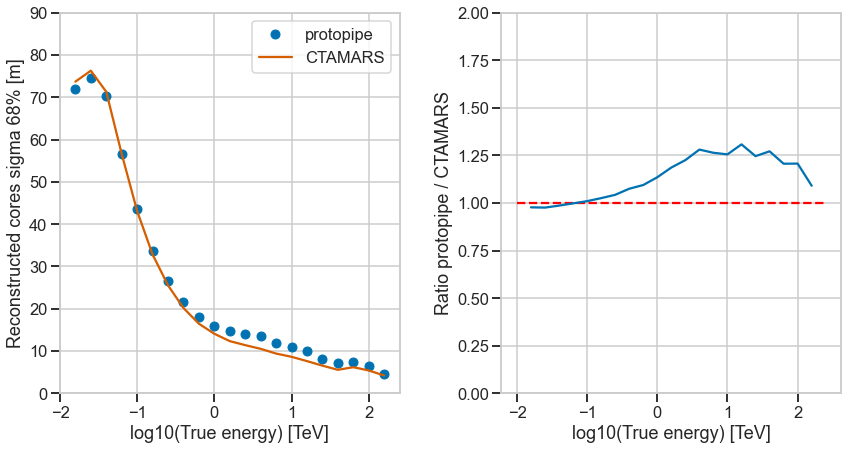

In [17]:
core_res = np.zeros(len(true_energy_bin_centers))

if load_CTAMARS:
    plt.figure(figsize=(14,7), tight_layout=False)
    plt.subplot(1, 2, 1)
    if use_seaborn:
        plt.subplots_adjust(wspace=0.3)
else:
    plt.figure(figsize=(7, 7))

plt.xlabel("log10(True energy) [TeV]")
plt.ylabel("Reconstructed cores sigma 68% [m]")

true_energy = np.log10(all_unique_reconstructed_showers["true_energy"])

true_core_x = all_unique_reconstructed_showers["mc_core_x"]
true_core_y = all_unique_reconstructed_showers["mc_core_y"]
reco_core_x = all_unique_reconstructed_showers["reco_core_x"]
reco_core_y = all_unique_reconstructed_showers["reco_core_y"]

core_distances = np.sqrt((true_core_x - reco_core_x)**2 + (true_core_y - reco_core_y)**2)

for i in range(len(true_energy_bin_centers)):

    mask = (true_energy > true_energy_bin_edges[i]) & (true_energy <= true_energy_bin_edges[i + 1])
    selected_core_distances = np.sort(core_distances[mask])
    if len(selected_core_distances)==0:
        core_res[i] = np.nan
    else:
        core_res[i] = np.percentile(selected_core_distances, 68.0)

if export_data:
    data_to_write = np.array([true_energy_bin_centers,core_res])
    np.savetxt(data_folder / f"training_reconstructed_shower_core_resolution_protopipe_{analysis_name}.csv",
               data_to_write.T,
               delimiter=',',
               header="True energy bin center [TeV], Reconstructed shower core resolution [deg]")

plt.plot(true_energy_bin_centers, core_res, 'o', label = "protopipe")

if superimpose_analysis_2:
    data_2 = np.genfromtxt(input_directory_data_2 / f"data/training_reconstructed_shower_core_resolution_protopipe_{analysis_name_2}.csv",
                          delimiter=',',
                          filling_values=True).T
    plt.plot(data_2[0], data_2[1], '-.', label = f"protopipe {analysis_name_2}")
    plt.legend()

plt.ylim(0, 90)

if load_CTAMARS:
    plt.plot(CTAMARS["coreres"].members["fX"], CTAMARS["coreres"].member("fY"), '-', label = "CTAMARS")
    plt.legend()

plt.grid(which="both", visible=True)

if load_CTAMARS:
    plt.subplot(1,2,2)

    plt.xlabel("log10(True energy) [TeV]")
    plt.ylabel("Ratio protopipe / CTAMARS")

    plt.plot(true_energy_bin_centers,
             core_res/CTAMARS["coreres"].member("fY"),
             '-')
    plt.hlines(1.0, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], linestyle= '--', color="red")
    plt.ylim(0, 2)

plt.savefig(plots_folder / f"training_reconstructed_shower_core_resolution_protopipe_{analysis_name}.png")
plt.show()

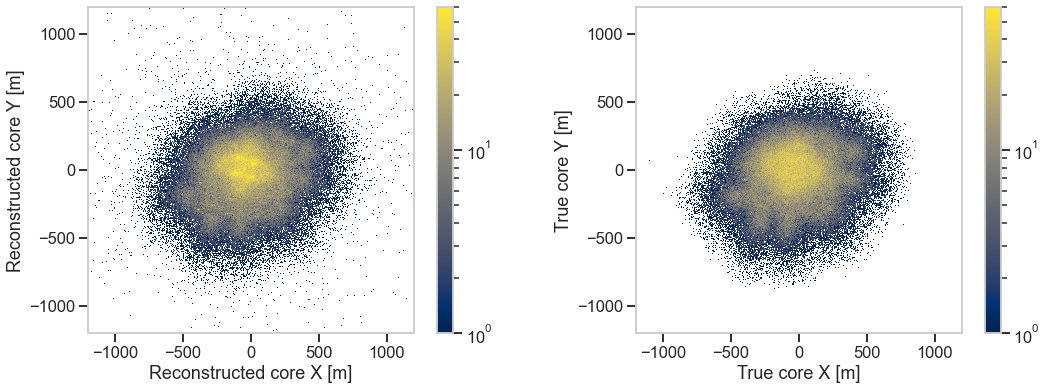

In [18]:
if load_CTAMARS:

    core_distribution_bin_edges_X = CTAMARS["histcore"].axes[0].edges()
    core_distribution_bin_edges_Y = CTAMARS["histcore"].axes[1].edges()

else:
    
    core_distribution_bin_edges_X = np.arange(-1200,1204,4)
    core_distribution_bin_edges_Y = np.arange(-1200,1204,4)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.gca().set_aspect('equal')

core_distribution = plt.hist2d(x = -all_unique_reconstructed_showers["reco_core_y"],
                               y = all_unique_reconstructed_showers["reco_core_x"],
                               bins=[core_distribution_bin_edges_X, core_distribution_bin_edges_Y],
                               cmap=cmap,
                               norm=LogNorm(vmin=1,vmax=60)
                               )

plt.colorbar()

# Superimpose telescopes positions if available
if tel_positions is not None:
    for tel_index in tel_positions.keys():
        plt.plot(-tel_positions[tel_index].value[1], tel_positions[tel_index].value[0], 'o', color="black")

plt.xlabel("Reconstructed core X [m]")
plt.ylabel("Reconstructed core Y [m]")

plt.subplot(1, 2, 2)
plt.gca().set_aspect('equal')

true_core_distribution = plt.hist2d(x = -all_unique_reconstructed_showers["mc_core_y"],
                           y = all_unique_reconstructed_showers["mc_core_x"],
                           bins=[core_distribution_bin_edges_X, core_distribution_bin_edges_Y],
                           cmap=cmap,
                           norm=LogNorm(vmin=1,vmax=60)
                           )
# Superimpose telescopes positions if available
if tel_positions is not None:
    for tel_index in tel_positions.keys():
        plt.plot(-tel_positions[tel_index].value[1], tel_positions[tel_index].value[0], 'o', color="black")

plt.colorbar()

plt.xlabel("True core X [m]")
plt.ylabel("True core Y [m]")
    
plt.savefig(plots_folder / f"training_reco_vs_true_cores_reco_events_protopipe_{analysis_name}.png")
plt.show()

### Correlation between H_max and atmospheric depth
[back to top](#Table-of-contents)

The correlation of the two quantities for the events in the "gamma-1" training sample is shown below for different arrays and different cuts in minimum number of valid images (in all cases no energy cut is applied to the events).

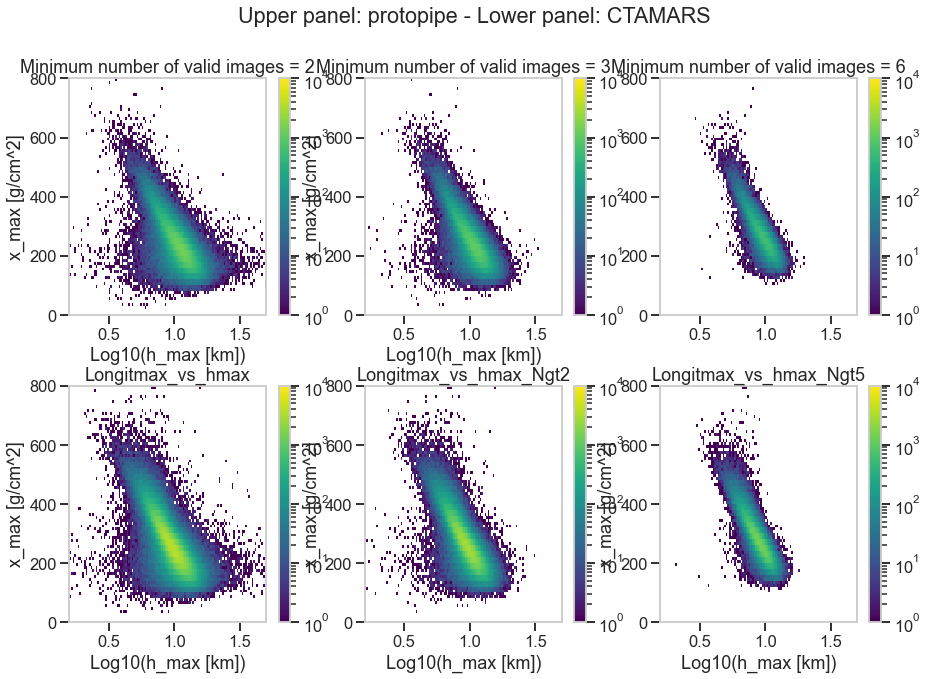

In [19]:
if load_CTAMARS:
    
    CTAMARS_plot = CTAMARS_data["Longitmax_vs_hmax"].to_numpy()

    hmax_xmax_bin_edges_X = CTAMARS_plot[1]
    hmax_xmax_bin_edges_Y = CTAMARS_plot[2]

else:
    
    hmax_xmax_bin_edges_X = np.arange(0.2, 1.7+0.0125, 0.0125)
    hmax_xmax_bin_edges_Y = np.arange(0, 810, 10)

plot_names = ['Longitmax_vs_hmax', 'Longitmax_vs_hmax_Ngt2', 'Longitmax_vs_hmax_Ngt5']

cmap = plt.cm.viridis

if load_CTAMARS:
    plt.figure(figsize=(15,10), tight_layout=False)
    n_rows = 2
    n_columns = 3
    plt.suptitle("Upper panel: protopipe - Lower panel: CTAMARS")
    plt.subplots_adjust(hspace=0.3)
else:
    plt.figure(figsize=(16, 5))
    n_rows = 1
    n_columns = 3

if load_CTAMARS:
    for i, plot_name in enumerate(plot_names):

        plt.subplot(n_rows, n_columns, n_columns+i+1)

        plt.xlabel("Log10(h_max [km])")
        plt.ylabel("x_max [g/cm^2]")
        plt.title(plot_name)

        CTAMARS_plot = CTAMARS_data[plot_name].to_numpy()

        CTAMARS_X_edges = CTAMARS_plot[1]
        CTAMARS_Y_edges = CTAMARS_plot[2]
        CTAMARS_values = CTAMARS_plot[0]

        plt.pcolormesh(CTAMARS_X_edges,
                       CTAMARS_Y_edges,
                       np.transpose(CTAMARS_values),
                       cmap=cmap,
                       norm=LogNorm(vmin=1, vmax=1.e4)
                       )
        plt.colorbar()

for i, n_images_reco in enumerate([2, 3, 6]):
    
    plt.xlabel("Log10(h_max [km])")
    plt.ylabel("x_max [g/cm^2]")
    
    reco_core_x = all_unique_reconstructed_showers["reco_core_x"]
    reco_core_y = all_unique_reconstructed_showers["reco_core_y"]

    core_distances = np.sqrt((reco_core_x)**2 + (reco_core_y)**2)
    
    mask = ((all_unique_reconstructed_showers["n_tel_reco"] >= n_images_reco) & (core_distances < 200.) )
    x_max = all_unique_reconstructed_showers["mc_x_max"][mask]
    h_max = all_unique_reconstructed_showers["h_max"][mask]/1.e3 # km

    plt.subplot(n_rows, n_columns, i+1)
    plt.hist2d(np.log10(h_max),
               x_max,
               bins=[hmax_xmax_bin_edges_X, hmax_xmax_bin_edges_Y],
               cmap=cmap,
               norm=LogNorm(vmin=1, vmax=1.e4))
    plt.colorbar()
    plt.title(f"Minimum number of valid images = {n_images_reco}")

plt.savefig(plots_folder / f"correlation_Hmax_atmospheric_depth_protopipe_{analysis_name}.png")
plt.show()

### Impact distances
[back to top](#Table-of-contents)

Cutting at 1km to avoid that the outliers effect dominates the plot

In [20]:
selection = "impact_dist < 1.e3 and is_valid==True"
selected_images = all_images.query(selection)

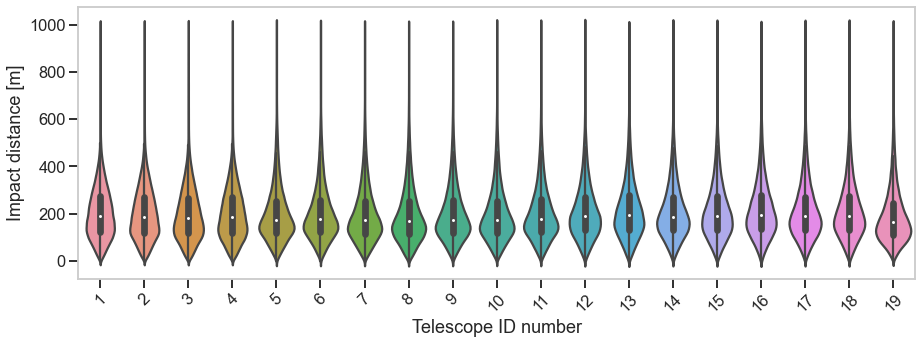

In [21]:
plt.figure(figsize=(15,5))
sns.violinplot(x = "tel_id",
               y = selected_images["impact_dist"],
               data=selected_images)
plt.xticks(rotation=45)
plt.ylabel("Impact distance [m]")
plt.xlabel("Telescope ID number")
plt.grid(axis="y")
None